# Learning from Small dataset: Probabilistic modeling



In this section you will find all the examples presented in the slides. Some bits of the code might be obscure at the beginning, they will be clearer after the lab ( hopefully :-) ! ) 

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

## One example: Linear Regression


In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm

[-0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5]


Text(0.5, 1.0, 'Observations')

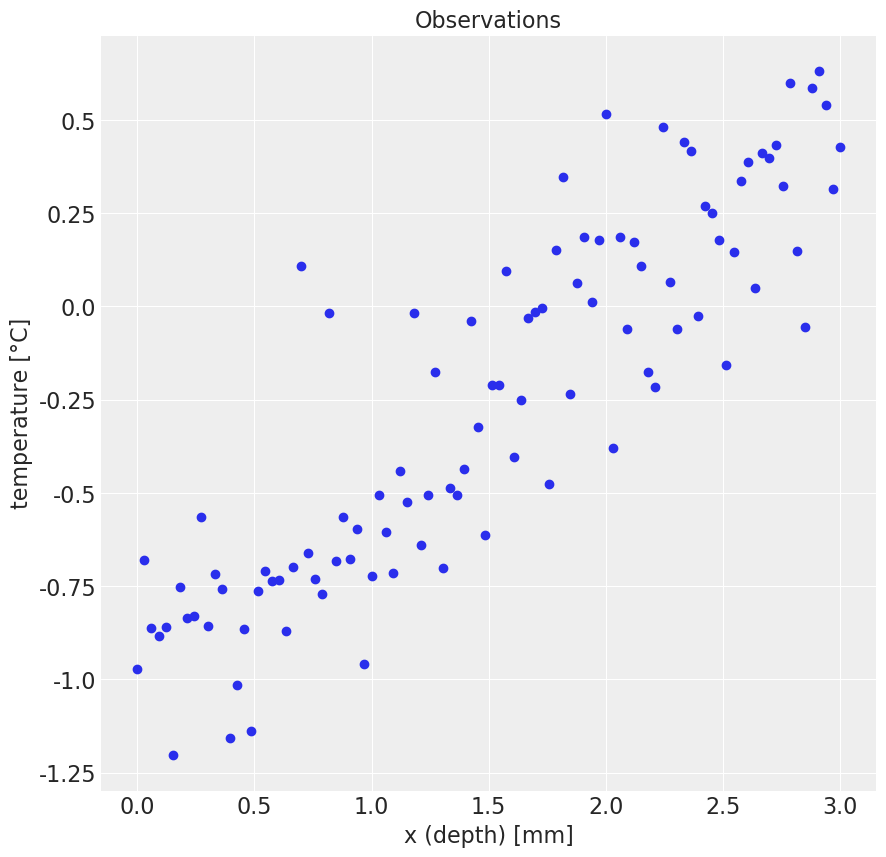

In [37]:
x = np.linspace(0, 3, 100)

data = -1 + 0.5 * x + 0.25* np.random.randn(1,len(x))


f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data)

print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)


In [38]:
with pm.Model() as model:   
    tau = pm.Gamma ('tau',1,1)    
    e = pm.Normal('e', 0, 1)  
    mu = pm.Normal('mu', 1, 1)  
    obs = pm.Normal("obs", mu = e + x * mu, sd = np.sqrt(tau), observed = data )

    ### Mysterious code to be explained in Chapter 3.
with model:
    trace = pm.sample(5000, tune=1000, chains=4)

mu = trace['mu']
tau = trace['tau']
e = trace['e']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, e, tau]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:19<00:00, 1229.78draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f31549b0198>,
      dtype=object)

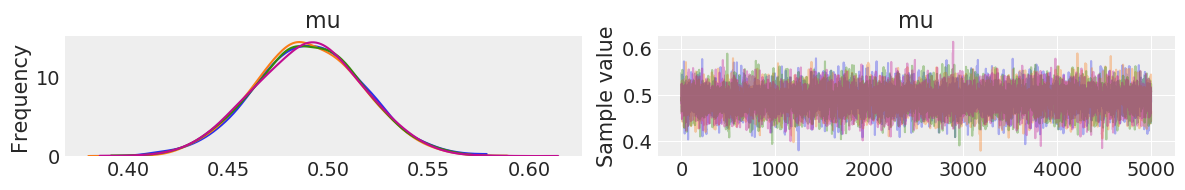

In [39]:
pm.traceplot(trace, varnames=['mu'])

[0. 1. 2. 3. 4. 5. 6. 7. 8.]


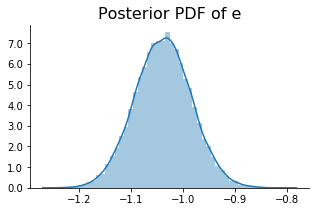

In [5]:

f,ax=plt.subplots(1,figsize=(5,3))
g1=sns.distplot(e, ax=ax)
ax.set_yticklabels(g1.axes.get_yticks(), fontsize = 10)
ax.set_title('Posterior PDF of e', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print(ax.get_yticks())


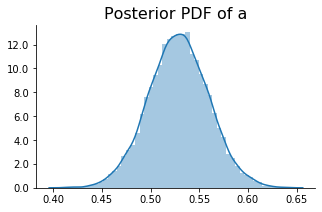

In [6]:

f,ax=plt.subplots(1,figsize=(5,3))
g1=sns.distplot(mu, ax=ax)
ax.set_yticklabels(g1.axes.get_yticks(), fontsize = 10)
ax.set_title('Posterior PDF of a', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


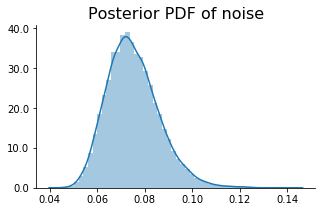

In [7]:

f,ax=plt.subplots(1,figsize=(5,3))
g1=sns.distplot(tau, ax=ax)
ax.set_yticklabels(g1.axes.get_yticks(), fontsize = 10)
ax.set_title('Posterior PDF of noise', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f315c56ceb8>,
      dtype=object)

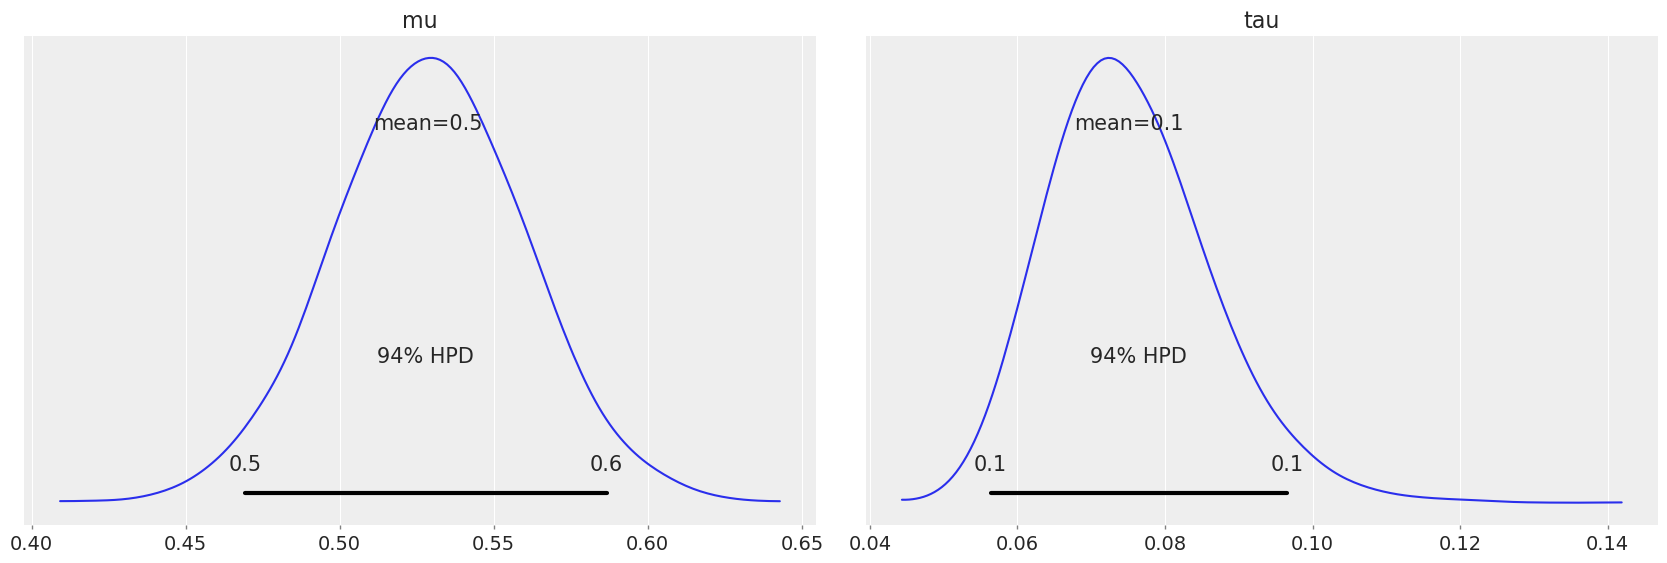

In [8]:
import arviz as az

az.style.use('arviz-darkgrid')
az.plot_posterior(trace, var_names=['mu', 'tau'])


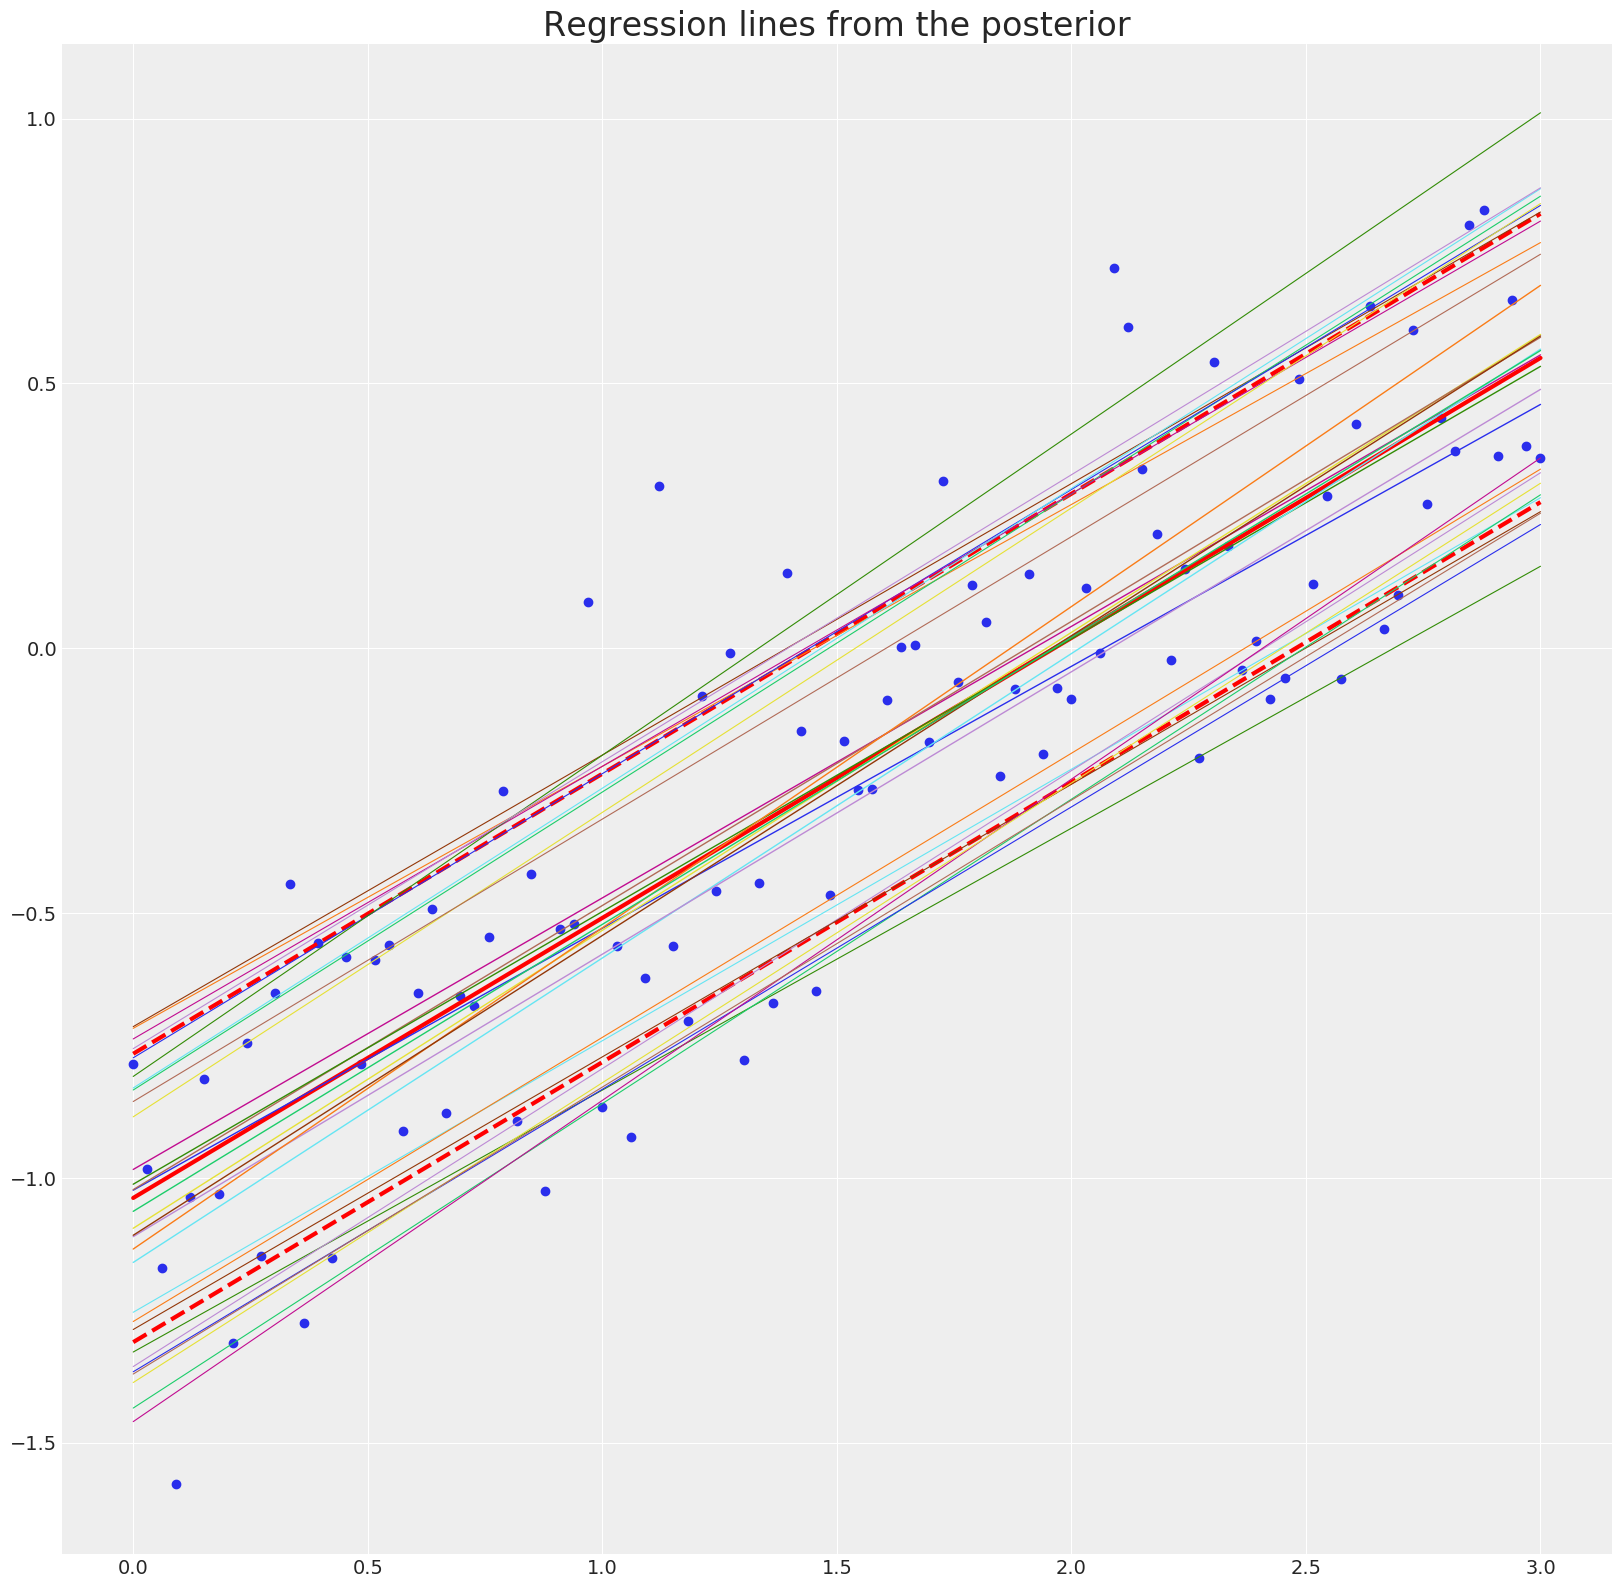

In [10]:
f,ax = plt.subplots(1, figsize=(20,20))
ax.set_title('Regression lines from the posterior', fontsize=24)
ax.scatter(x, data)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(x, np.median(e) + x * np.median(mu), 'r', lw=3)
ax.plot(x, np.median(e) + x * np.median(mu) + np.sqrt(np.median(tau)), 'r--', lw=3)
ax.plot(x, np.median(e) + x * np.median(mu) - np.sqrt(np.median(tau)), 'r--', lw=3)

for i in np.linspace(2000,3999, 10):
    i = int(i)
    
    ax.plot(x, e[i] + x * mu[i], lw=1)
    ax.plot(x, e[i] + x * mu[i] + np.sqrt(tau[i]), lw=.8,)
    ax.plot(x, e[i] + x * mu[i] - np.sqrt(tau[i]), lw=0.8 )


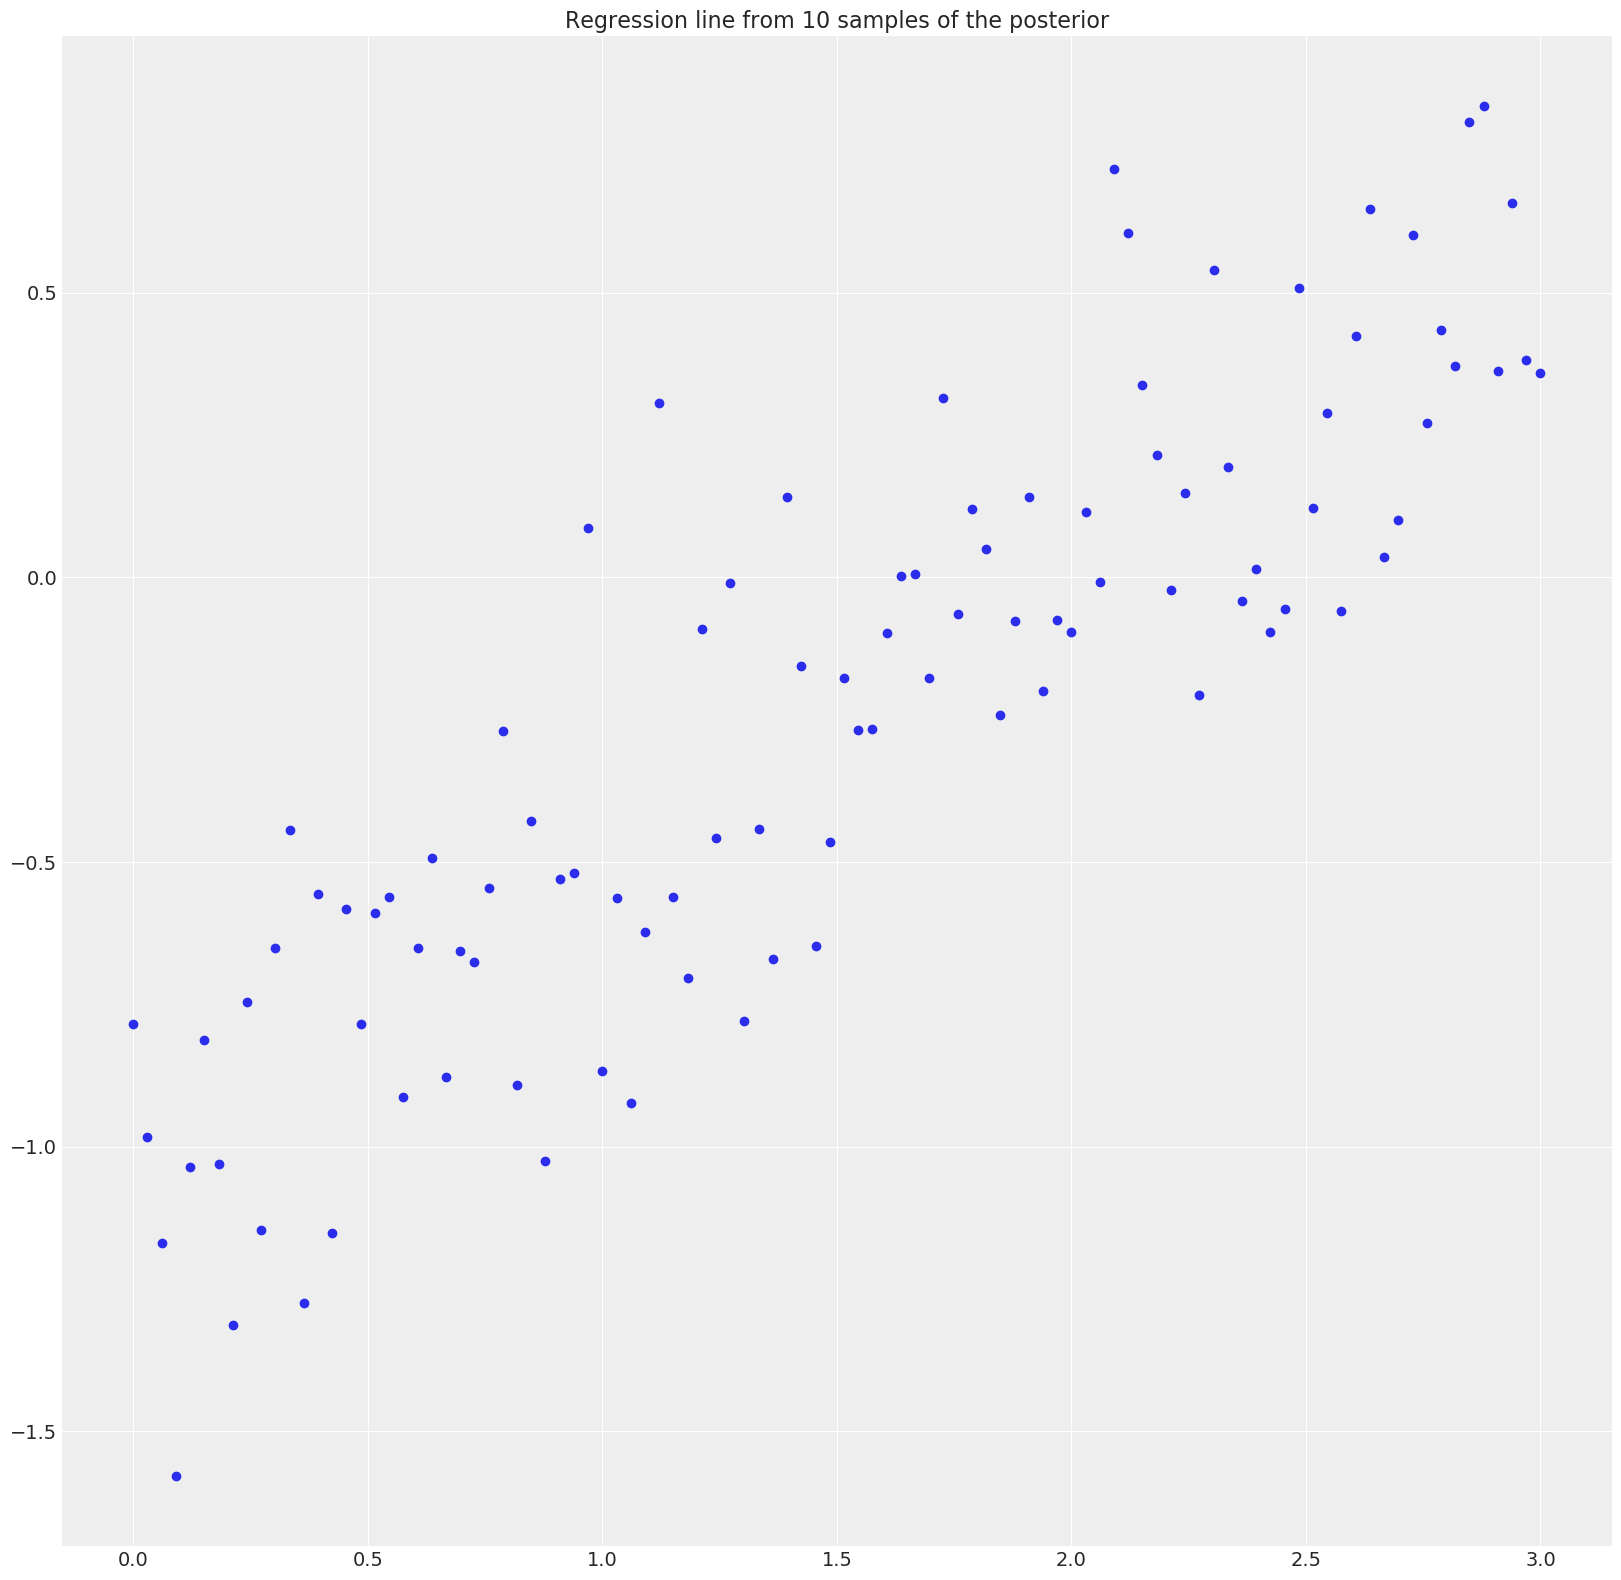

In [11]:
f,ax = plt.subplots(1, figsize=(20,20))
ax.set_title('Regression line from 10 samples of the posterior', fontsize=16)
ax.scatter(x, data)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



Approximate Bayesian Computation
============================

We run a restaurant for a company and we need to order the right amount of fresh food every day
to avoid spoiling it. We want to decide how many burgers are going to be served.

On the first day, 18/30 customers ordered a burger.

**Observed data**: 18/30 burgers


What do we need for the bayes formula? 

- Prior: P( param )
- We need evidence: P ( data )
- We need a likelihood : P( data | param )

### How can we formulate the problem in terms of statistics?

We need a model to represent our scenario! 
We are observing the probability of something happening after a number of trials...

From Wikipedia:
**the binomial distribution** with parameters n and p is the discrete probability distribution of the number of successes in a sequence of n independent experiments, each asking a yes–no question. 

p = [0,1]

It's what we need. 



[0.05, 0.15000000000000002, 0.25, 0.35000000000000003, 0.45, 0.5499999999999999, 0.6499999999999999, 0.75, 0.85, 0.95]


Text(0, 0.5, 'Samples count \n s.t. binom(sample,30)=11')

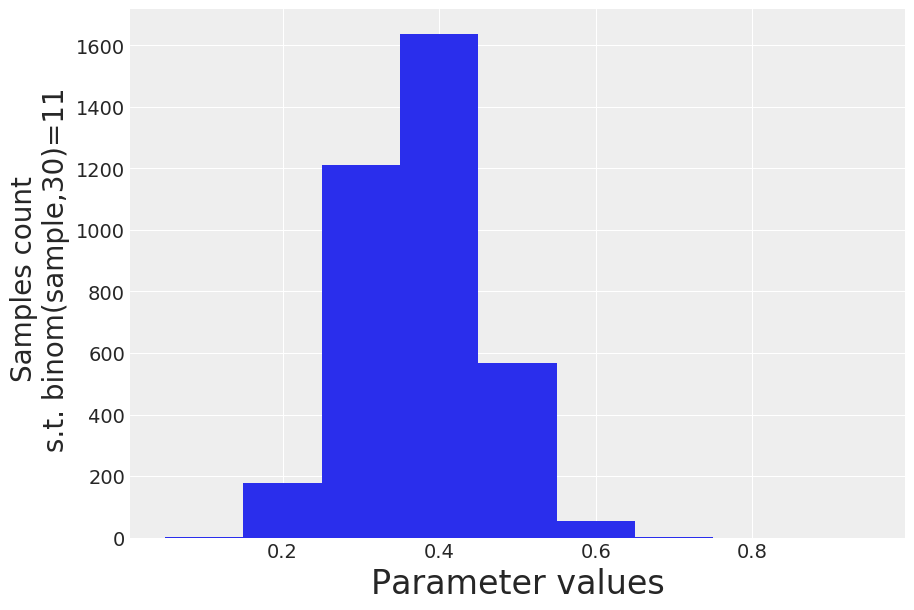

In [12]:
obs = 11
n = 30

params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
bins = [i-0.05 for i in params]
bins.append(0.95)
print(bins)

counts = []
likelihood = []
for i in range(100000):
    prior_sample = np.random.choice(params) # Uniform
    counts.append(prior_sample)
    sample = np.random.binomial(n, prior_sample)    
    
    if int(sample) == obs:
        likelihood.append(prior_sample)

f,ax=plt.subplots(1, figsize=(10,7))
h = ax.hist(likelihood, bins = bins)
ax.set_xlabel('Parameter values', fontsize=24)
ax.set_ylabel('Samples count \n s.t. binom(sample,30)=11', fontsize=20)


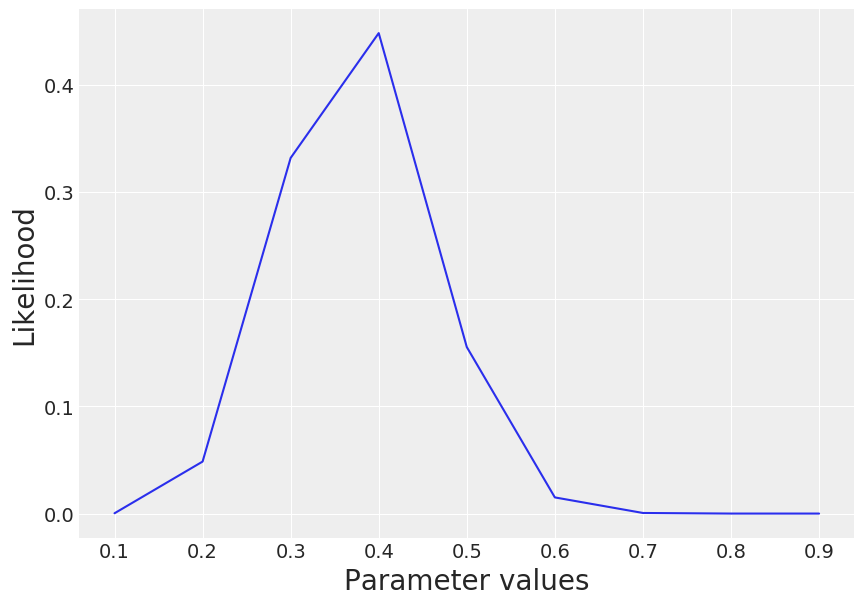

In [13]:
f,ax=plt.subplots(1, figsize=(10,7))
plt.plot(params,h[0]/np.sum(h[0]))
ax.set_xlabel('Parameter values', fontsize=20)
ax.set_ylabel('Likelihood', fontsize=20)

lh= h[0]/np.sum(h[0])


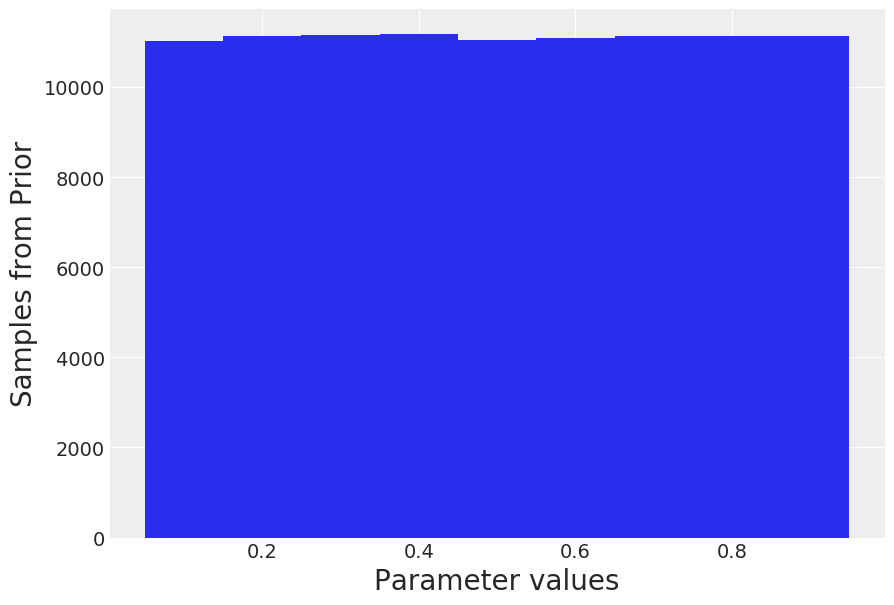

In [14]:
f,ax=plt.subplots(1, figsize=(10,7))
h1=ax.hist(counts, bins=bins)
ax.set_xlabel('Parameter values', fontsize=20)
ax.set_ylabel('Samples from Prior', fontsize=20)

pr=h1[0]/np.sum(h1[0])

Text(0, 0.5, 'Posterior')

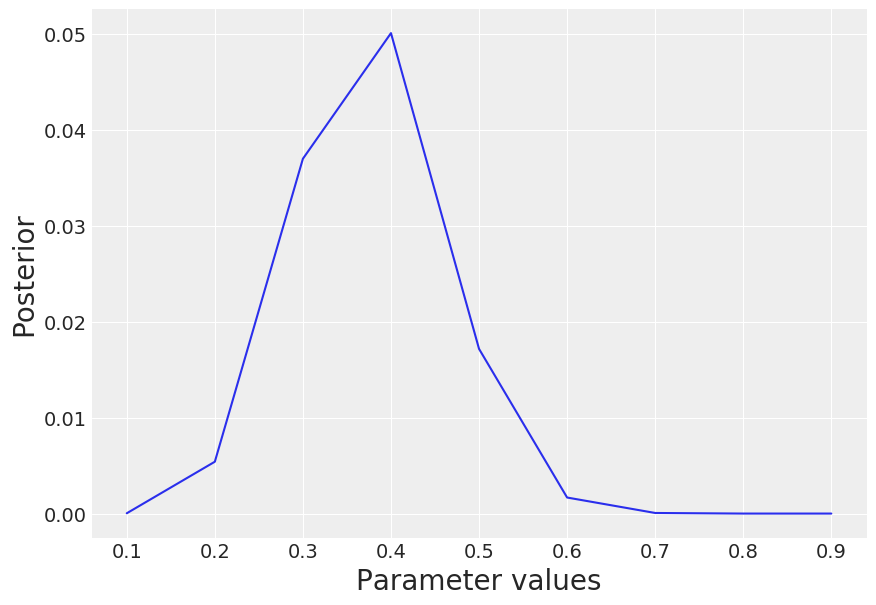

In [15]:
f,ax=plt.subplots(1, figsize=(10,7))
ax.plot(params, lh*pr)
ax.set_xlabel('Parameter values', fontsize=20)
ax.set_ylabel('Posterior', fontsize=20)

## The choice of priors
 

Let's see how different priors affect the posterior of a coin toss experiment

### First let's see some examples of beta distributions

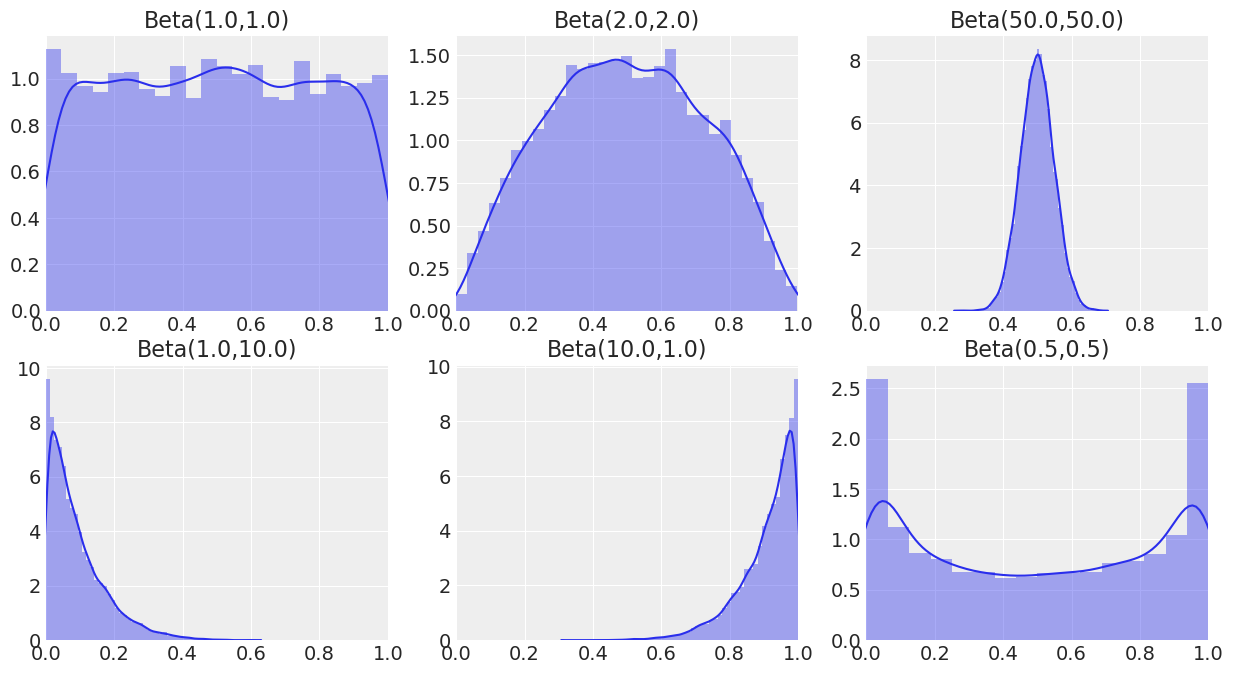

In [16]:
f,axes = plt.subplots(2,3, figsize= (15,8))
params = np.array([[(1,1), (2,2), (50,50)],[(1,10), (10,1), (.5,.5)]])
x = np.linspace(0,1,10000)

for i,r in enumerate(axes):
    for j,ax in enumerate(r):
        ax.set_xlim(0,1)
        sns.distplot(np.random.beta(params[i][j][0],params[i][j][1], len(x)), ax=ax)
        ax.set_title('Beta(%s,%s)' %(str(params[i,j][0]), str(params[i,j][1])))

### Now we are going to build the model using different priors and the same observations.

In [17]:
observation = np.array([1.,0.])

Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [prob]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:03<00:00, 7134.50draws/s]
The number of effective samples is smaller than 25% for some parameters.


Text(0.5, 1.0, 'Posterior')

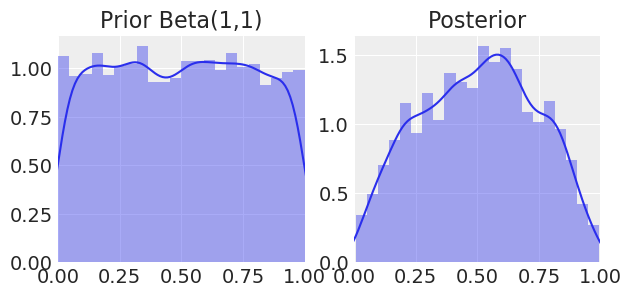

In [18]:
# Prior Beta(1,1), uniform prior
a=1
b=1
with pm.Model() as model:    
    prob = pm.Beta('prob', alpha = a, beta = b)    
    obs = pm.Bernoulli("obs", p=prob, observed = observation)

    ### Mysterious code to be explained later
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=5000,step=step, chains=4)
    
posterior = trace['prob']

f,axes = plt.subplots(1,2, figsize= (7,3))
axes[0].set_xlim(0,1)
sns.distplot(np.random.beta(a,b, 10000), ax=axes[0])
axes[0].set_title('Prior Beta(%s,%s)' %(a,b))
axes[1].set_xlim(0,1)
sns.distplot(posterior, ax=axes[1])
axes[1].set_title('Posterior')

Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [prob]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:03<00:00, 6759.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


Text(0.5, 1.0, 'Posterior')

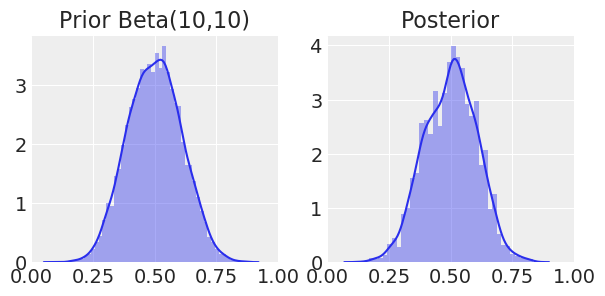

In [19]:
# Prior Beta(10,10)
a=10
b=10
with pm.Model() as model:    
    prob = pm.Beta('prob', alpha = a, beta = b)    
    obs = pm.Bernoulli("obs", p=prob, observed = observation)

    ### Mysterious code to be explained later
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=5000,step=step, chains=4)
    
posterior = trace['prob']

f,axes = plt.subplots(1,2, figsize= (7,3))
axes[0].set_xlim(0,1)
sns.distplot(np.random.beta(a,b, 10000), ax=axes[0])
axes[0].set_title('Prior Beta(%s,%s)' %(a,b))
axes[1].set_xlim(0,1)
sns.distplot(posterior, ax=axes[1])
axes[1].set_title('Posterior')

Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [prob]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:03<00:00, 6114.93draws/s]
The number of effective samples is smaller than 25% for some parameters.


Text(0.5, 1.0, 'Posterior')

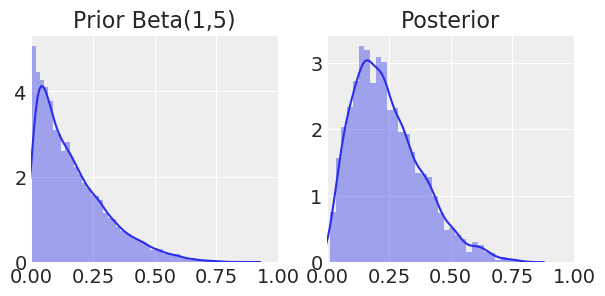

In [20]:
# Prior Beta(1,5)
a=1
b=5
with pm.Model() as model:    
    prob = pm.Beta('prob', alpha = a, beta = b)    
    obs = pm.Bernoulli("obs", p=prob, observed = observation)

with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=5000,step=step, chains=4)
    
posterior = trace['prob']

f,axes = plt.subplots(1,2, figsize= (7,3))
axes[0].set_xlim(0,1)
sns.distplot(np.random.beta(a,b, 10000), ax=axes[0])
axes[0].set_title('Prior Beta(%s,%s)' %(a,b))
axes[1].set_xlim(0,1)
sns.distplot(posterior, ax=axes[1])
axes[1].set_title('Posterior')

### Let's now increase the observation size

In [21]:

observation = np.array([1.,0.,1.,0.,1.,0.,1.,0.,1.,0.,1.,0.,1.,0.,1.,0.,1.,0.,1.,0.,1.,0.,1.,0.,1.,0.])



Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [prob]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:03<00:00, 7648.88draws/s]
The number of effective samples is smaller than 25% for some parameters.


Text(0.5, 1.0, 'Posterior')

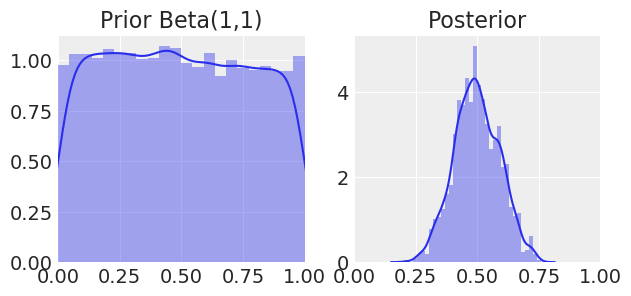

In [22]:
# Prior Beta(1,1), uniform prior
a=1
b=1
with pm.Model() as model:    
    prob = pm.Beta('prob', alpha = a, beta = b)    
    obs = pm.Bernoulli("obs", p=prob, observed = observation)

with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=5000,step=step, chains=4)
    
posterior = trace['prob']
f,axes = plt.subplots(1,2, figsize= (7,3))
axes[0].set_xlim(0,1)
sns.distplot(np.random.beta(a,b, 10000), ax=axes[0])
axes[0].set_title('Prior Beta(%s,%s)' %(a,b))
axes[1].set_xlim(0,1)
sns.distplot(posterior, ax=axes[1])
axes[1].set_title('Posterior')

Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [prob]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:03<00:00, 6566.72draws/s]
The number of effective samples is smaller than 25% for some parameters.


Text(0.5, 1.0, 'Posterior')

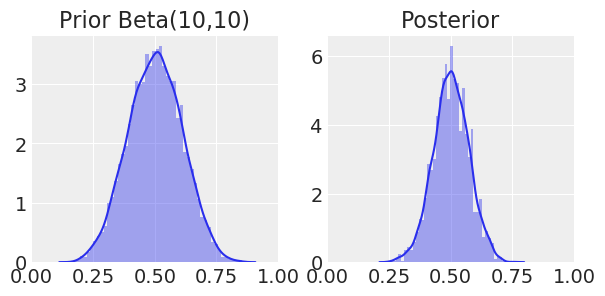

In [23]:
# Prior Beta(10,10)
a=10
b=10
with pm.Model() as model:    
    prob = pm.Beta('prob', alpha = a, beta = b)    
    obs = pm.Bernoulli("obs", p=prob, observed = observation)

    ### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=5000,step=step, chains=4)
    
posterior = trace['prob']

f,axes = plt.subplots(1,2, figsize= (7,3))
axes[0].set_xlim(0,1)
sns.distplot(np.random.beta(a,b, 10000), ax=axes[0])
axes[0].set_title('Prior Beta(%s,%s)' %(a,b))
axes[1].set_xlim(0,1)
sns.distplot(posterior, ax=axes[1])
axes[1].set_title('Posterior')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [prob]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:09<00:00, 2422.64draws/s]
The acceptance probability does not match the target. It is 0.8910183217488118, but should be close to 0.8. Try to increase the number of tuning steps.


Text(0.5, 1.0, 'Posterior')

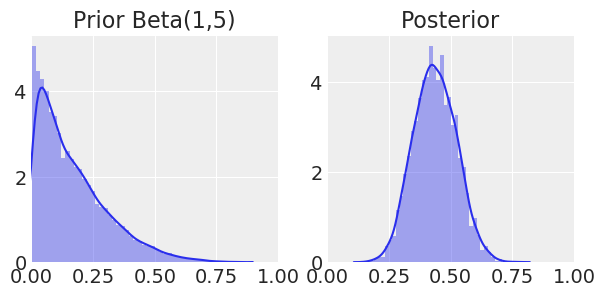

In [24]:
# Prior Beta(1,10)
a=1
b=5
with pm.Model() as model:    
    prob = pm.Beta('prob', alpha = a, beta = b)    
    obs = pm.Bernoulli("obs", p=prob, observed = observation)

    ### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=5000, chains=4)
    
posterior = trace['prob']

f,axes = plt.subplots(1,2, figsize= (7,3))
axes[0].set_xlim(0,1)
sns.distplot(np.random.beta(a,b, 10000), ax=axes[0])
axes[0].set_title('Prior Beta(%s,%s)' %(a,b))
axes[1].set_xlim(0,1)
sns.distplot(posterior, ax=axes[1])
axes[1].set_title('Posterior')